In [ ]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'ibm_gestures'
total_time = 50
batch_size = 64

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 32,
                  crop_to=1e6)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[CropTime(min=0, max=1000000.0), Downsample(time_factor=1, spatial_factor=0.25, sensor_size=None, target_size=None), ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


### Conv3D + 2 layer feedforward With 10 delays

In [2]:
num_epochs = 20

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4         
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 24, 
        'kernel_size': 4,
        'fanin_delays': 10 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 128, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 128, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 10, 'stride': 1}
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)



Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv3DSNNLayer(
      (conv): Conv3d(16, 24, kernel_size=(10, 4, 4), stride=(1, 4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=128, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=1280, out_features=128, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)


Epoch [1/20], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [5/16], Loss: 2.34753
Step [10/16], Loss: 1.99633
Step [15/16], Loss: 1.80112
Time elasped: 60.05453944206238
264
Test Loss: 1.6459938764572144
Avg spk_count per neuron for all 50 time-steps 1934.5886363636362
Test Accuracy of the model on the test samples: 42.803

max acc: 42.803030303030305
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 1.44836
Step [10/16], Loss: 1.34465
Step [15/16], Loss: 1.06479
Time elasped: 5.664928674697876
264
Test Loss: 1.1436500549316406
Avg spk_count per neuron for all 50 time-steps 1946.7946969696968
Test Accuracy of the model on the test samples: 50.379

max acc: 50.378787878787875
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 0.92990
Step [10/16], Loss: 0.97512
Step [15/16], Loss: 0.99802
Time elasped: 6.076937675476074
264
Test Loss: 1.1337652206420898
Avg spk_count per neuron for all 50 time-steps 1845.2075757575758
Test Accuracy of the model on the test samples: 53.788

max acc: 53.78787878787879
Epoch [4

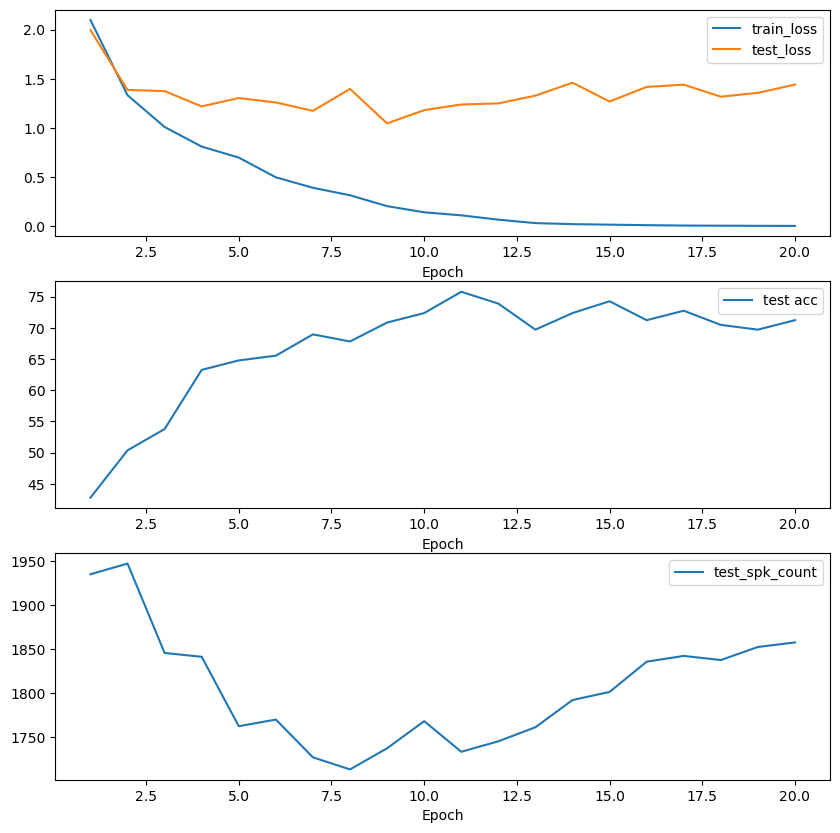

In [3]:
#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

### Similar to BAM-SLDK
Same number of layers and num_outs, similar kernels sizes, but convs have no delays. Also no average-pooling, no BNTT.

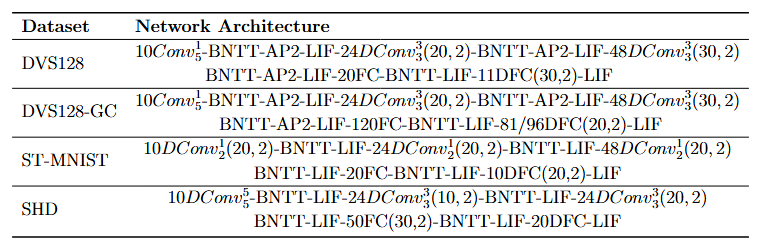

In [1]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal

device = get_device()

dataset = 'ibm_gestures'
total_time = 50
batch_size = 32

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 64,
                  crop_to=3e6) # verified in BAM-SLDK code

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[CropTime(min=0, max=3000000.0), Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None), ToFrame(sensor_size=(64, 64, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 10, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv3DSNNLayer(
      (conv): Conv3d(10, 24, kernel_size=(20, 4, 4), stride=(1, 4, 4), bias=False)
    )
    (2): Conv3DSNNLayer(
      (conv): Conv3d(24, 48, kernel_size=(30, 2, 2), stride=(1, 2, 2), bias=False)
    )
    (3): FlattenSNNLayer()
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=2880, out_features=20, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=20, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 2.04674
Step [22/33], Loss: 1.67560
Step [33/33], Loss: 1.42334
Time elasped: 100.77692675590515
264
Test Loss: 1.4499694506327312
Avg spk_count per neuron for all 50 time-steps 3303.2772727272727
Test Accuracy of the model on the test samples: 45.455

max acc: 45.45454545454545
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 1.21220
Step [22/33], Loss: 1.51238
Step [33/33], Loss: 1.16110
Time elasped: 13.617589235305786
264
Test Loss: 1.178121851550208
Avg spk_count per neuron for all 50 time-steps 3296.478787878788
Test Accuracy of the model on the test samples: 54.924

max acc: 54.92424242424242
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 1.04604
Step [22/33], Loss: 1.06422
Step [33/33], Loss: 1.15822
Time elasped: 16.80411982536316
264
Test Loss: 1.0792225400606792
Avg spk_count per neuron for all 50 time-steps 3142.505303030303
Test Accuracy of the model on the test samples: 59.848

max acc: 59.84848484848485
Epoch [4

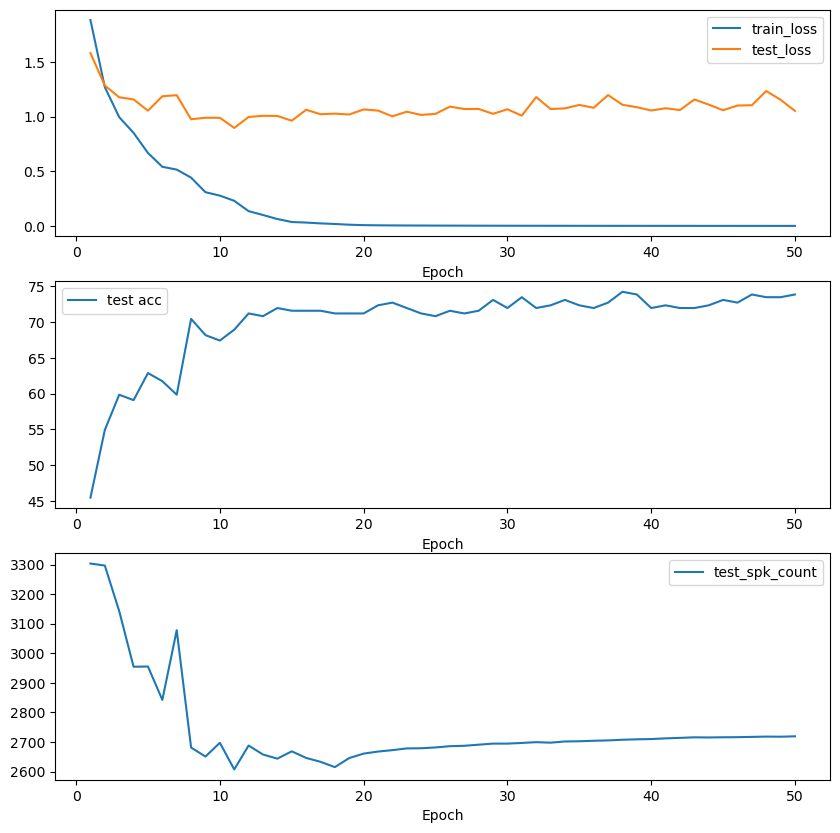

In [ ]:
num_epochs = 50

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 10, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 24, 
        'kernel_size': 4,
        'fanin_delays': 20
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 48, 
        'kernel_size': 2,
        'fanin_delays': 30
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 20, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 30, 'stride': 2}
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

In [11]:
lr = 5e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 10, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 24, 
        'kernel_size': 4,
        'fanin_delays': 20
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 48, 
        'kernel_size': 2,
        'fanin_delays': 30
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 20, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 30, 'stride': 2}
        
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 10, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv3DSNNLayer(
      (conv): Conv3d(10, 24, kernel_size=(20, 4, 4), stride=(1, 4, 4), bias=False)
    )
    (2): Conv3DSNNLayer(
      (conv): Conv3d(24, 48, kernel_size=(30, 2, 2), stride=(1, 2, 2), bias=False)
    )
    (3): FlattenSNNLayer()
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=2880, out_features=20, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=20, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)


Filter shape: (20, 4, 4)


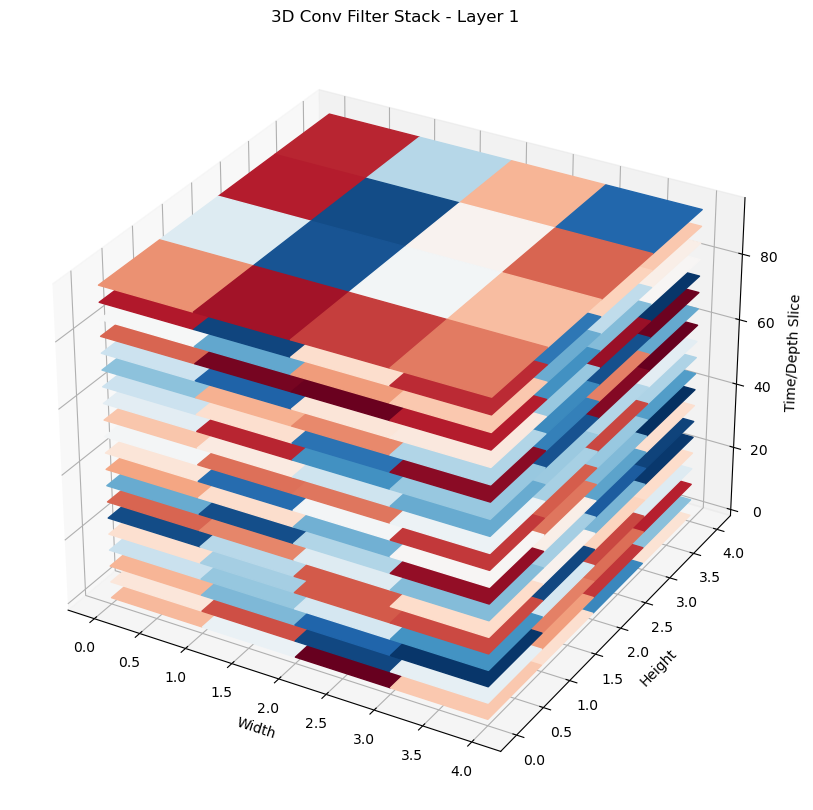

In [12]:
from snn_delays.utils.visualization_utils import plot_3d_conv_filter_stack
plot_3d_conv_filter_stack(snn.layers[1].conv.weight.data.cpu().numpy()[0, 0, :, :, :], title="3D Conv Filter Stack - Layer 1")

[Parameter containing:
tensor([[[[ 0.0499,  0.1340,  0.0858, -0.0978],
          [ 0.1242,  0.1688, -0.0030, -0.1529],
          [ 0.0713,  0.0225, -0.0986,  0.0363],
          [-0.0024,  0.1044, -0.1764,  0.1244]],

         [[-0.0542, -0.1542,  0.1561,  0.1312],
          [ 0.0730,  0.1348, -0.1614, -0.0985],
          [-0.0352, -0.0398, -0.0985,  0.0978],
          [ 0.0540,  0.0518,  0.1151,  0.0722]]],


        [[[-0.1597, -0.0708,  0.0761, -0.1763],
          [-0.0981, -0.1737,  0.1049,  0.0910],
          [ 0.0734, -0.0900, -0.0216, -0.0397],
          [-0.0911, -0.1010, -0.1746, -0.0981]],

         [[ 0.0216, -0.0086,  0.0526,  0.0092],
          [-0.0597,  0.0271,  0.0177,  0.1753],
          [ 0.1031, -0.1556, -0.1511,  0.0571],
          [ 0.1131, -0.1579, -0.0271,  0.0972]]],


        [[[-0.0399,  0.0712,  0.1212,  0.0485],
          [ 0.0808,  0.1379,  0.0290, -0.1369],
          [ 0.1751, -0.0340,  0.1712,  0.1276],
          [ 0.0381,  0.0652, -0.0719,  0.0540]],

   

c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 0.08408
Step [22/33], Loss: 0.07345
Step [33/33], Loss: 0.06824
Time elasped: 13.163198709487915
264
Test Loss: 0.0616526525053713
Avg spk_count per neuron for all 50 time-steps 3877.9386363636363
Test Accuracy of the model on the test samples: 43.182

max acc: 43.18181818181818
Epoch [2/20], learning_rates 0.005000, 0.100000
Step [11/33], Loss: 0.06018
Step [22/33], Loss: 0.05055
Step [33/33], Loss: 0.04574
Time elasped: 13.41139554977417
264
Test Loss: 0.06041906732651922
Avg spk_count per neuron for all 50 time-steps 4064.9863636363643
Test Accuracy of the model on the test samples: 50.000

max acc: 50.0
Epoch [3/20], learning_rates 0.005000, 0.100000
Step [11/33], Loss: 0.05112
Step [22/33], Loss: 0.05531
Step [33/33], Loss: 0.05762
Time elasped: 17.486591577529907
264
Test Loss: 0.05759684410360125
Avg spk_count per neuron for all 50 time-steps 3933.265151515151
Test Accuracy of the model on the test samples: 49.242

max acc: 50.0
Epoch [4/20], learning_rates 0

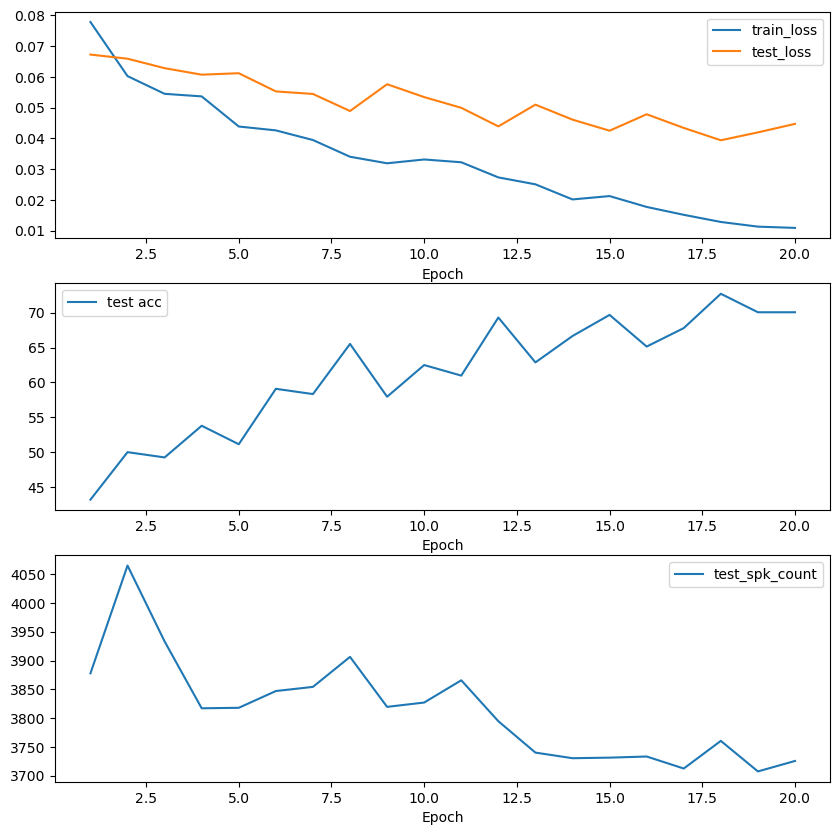

In [13]:
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Filter shape: (20, 4, 4)


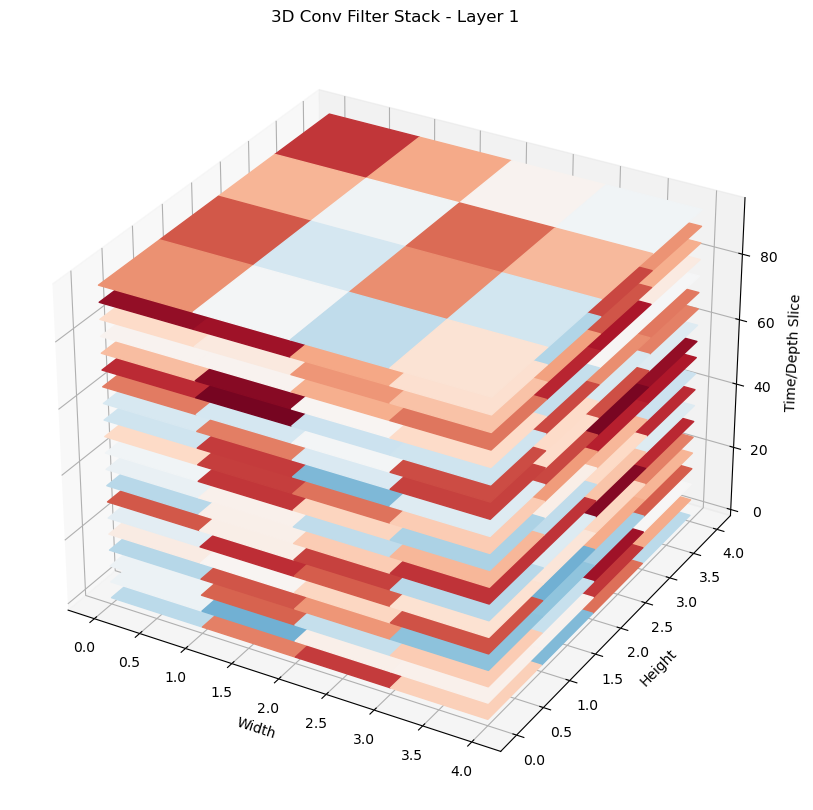

In [10]:
plot_3d_conv_filter_stack(snn.layers[1].conv.weight.data.cpu().numpy()[0, 0, :, :, :], title="3D Conv Filter Stack - Layer 1")

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv3DSNNLayer(
      (conv): Conv3d(2, 16, kernel_size=(5, 4, 4), stride=(1, 4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=384, out_features=96, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=960, out_features=96, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[[-0.0066, -0.0027, -0.0296,  0.0182],
           [-0.0452, -0.0139,  0.0306,  0.0742],
           [ 0.0186, -0.0268,  0.0076, -0.0089],
           [ 0.0323,  0.0091,  0.0310,  0.0767]],

          [[-0.0328, -0.0028,  0.0182, -0.0005],
           [-0.0076, -0.0700, -0.0682, -0.0711],
           [-0.0774, -0.0736, -0.0599, -0.07

c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 0.09001
Step [22/33], Loss: 0.08896
Step [33/33], Loss: 0.08222
Time elasped: 108.32408142089844
264
Test Loss: 0.0835702038473553
Avg spk_count per neuron for all 50 time-steps 6168.022727272727
Test Accuracy of the model on the test samples: 27.273

max acc: 27.272727272727273
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.07968
Step [22/33], Loss: 0.07046
Step [33/33], Loss: 0.07674
Time elasped: 11.10384726524353
264
Test Loss: 0.07284015251530541
Avg spk_count per neuron for all 50 time-steps 6458.063636363637
Test Accuracy of the model on the test samples: 35.606

max acc: 35.60606060606061
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.05855
Step [22/33], Loss: 0.06508
Step [33/33], Loss: 0.05699
Time elasped: 11.473567008972168
264
Test Loss: 0.05958030455642276
Avg spk_count per neuron for all 50 time-steps 6630.988636363636
Test Accuracy of the model on the test samples: 49.242

max acc: 49.24242424242424
Epoch

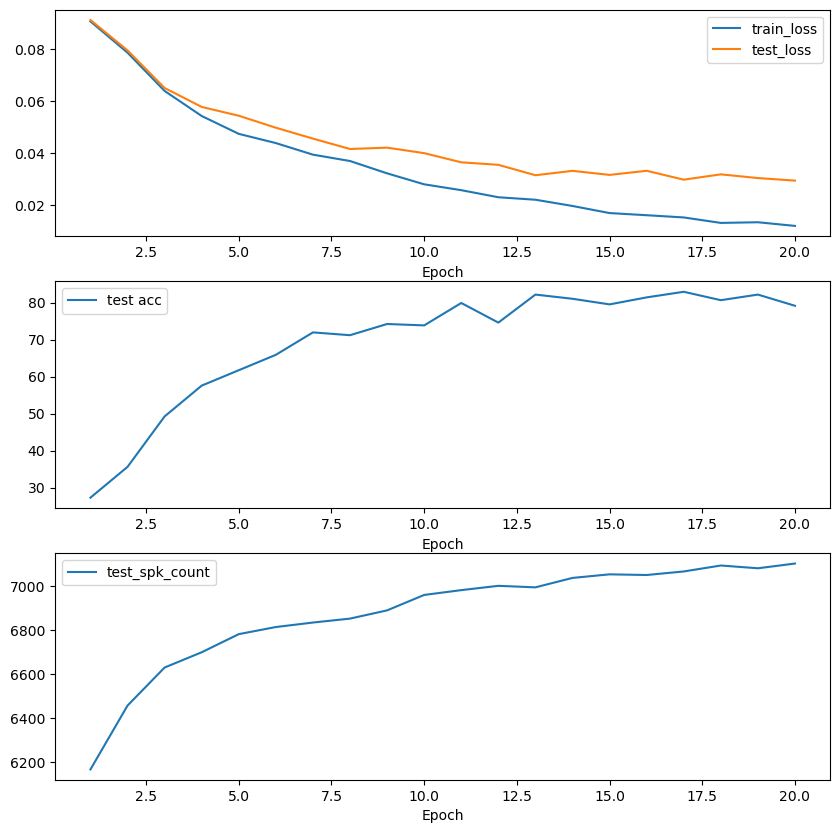

In [3]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv3D', 
        'out_channels': 16, 
        'kernel_size': 4, 
        'fanin_delays': 5
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 96, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 10, 'stride': 1}
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv3DSNNLayer(
      (conv): Conv3d(2, 16, kernel_size=(5, 4, 4), stride=(1, 4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=384, out_features=96, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[[-2.9326e-03,  2.7158e-02, -4.1574e-02,  2.0925e-02],
           [ 2.2490e-02, -2.4008e-02,  4.6853e-03, -6.4024e-02],
           [-3.7063e-02,  5.1383e-02,  5.7168e-02, -1.2094e-02],
           [-7.3221e-02,  7.3301e-02, -4.2811e-02,  9.0957e-03]],

          [[ 4.6102e-02,  1.4164e-02,  3.6719e-02,  5.4244e-03],
           [ 7

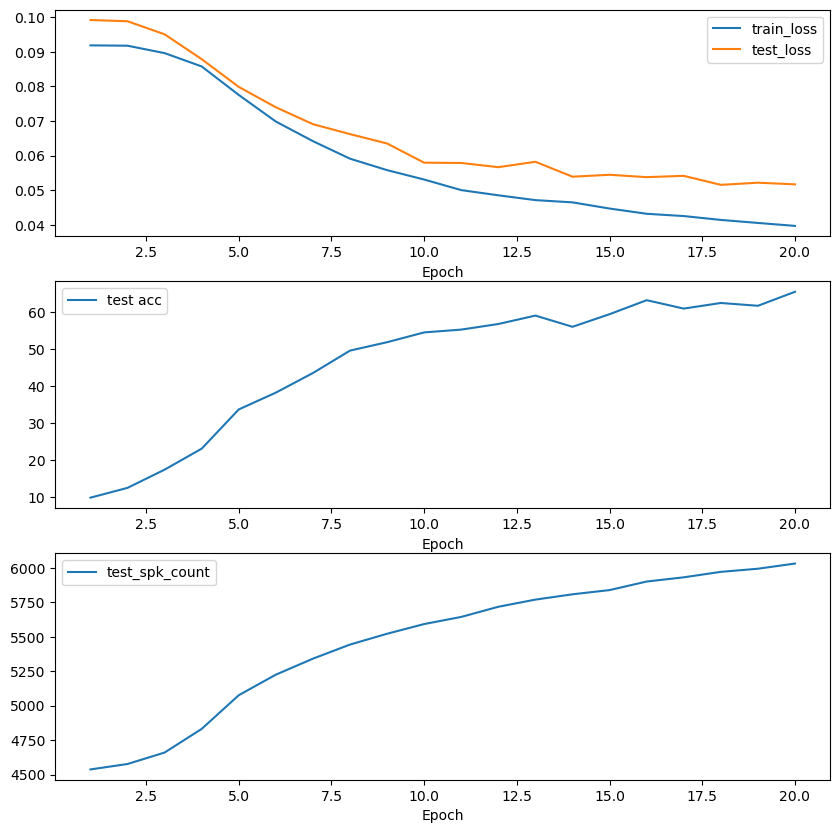

In [4]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv3D', 
        'out_channels': 16, 
        'kernel_size': 4, 
        'fanin_delays': 5
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=384, out_features=96, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[-1.6209e-02, -1.6793e-01,  1.4784e-01, -1.0155e-01],
          [-1.3654e-01,  7.0813e-02, -1.2073e-01, -1.7447e-01],
          [-3.9847e-02, -1.2767e-01,  5.7239e-02, -6.6919e-02],
          [-9.3010e-02, -1.2313e-01, -9.1360e-02, -3.2683e-02]],

         [[-1.0696e-01, -5.8847e-02, -1.0463e-01, -3.5456e-02],
          [-9.3532e-02,  

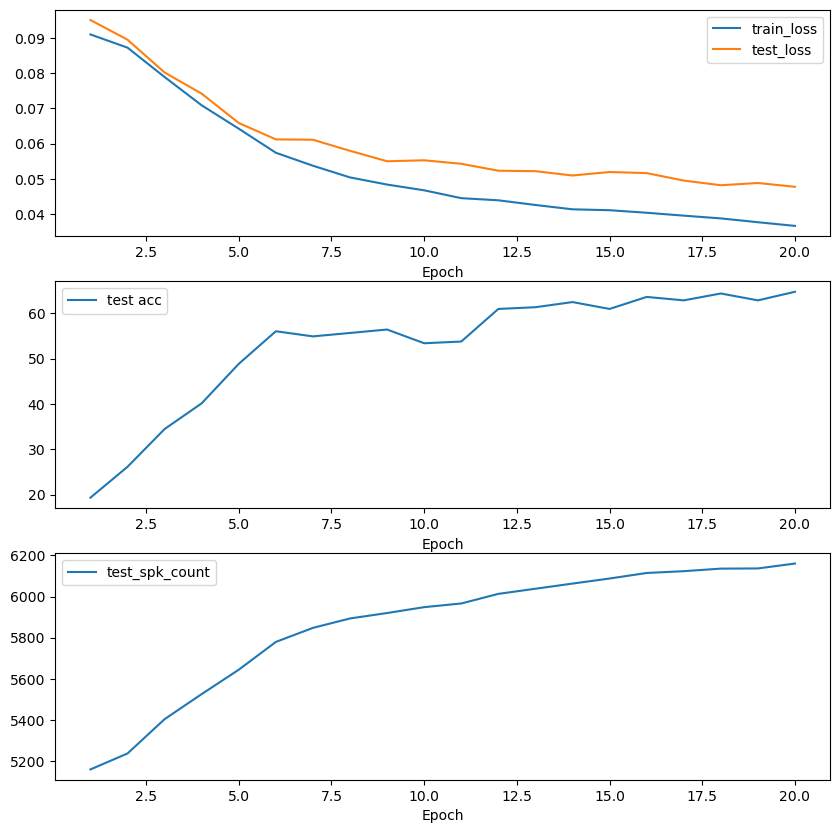

In [5]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv3DSNNLayer(
      (conv): Conv3d(2, 16, kernel_size=(2, 4, 4), stride=(1, 4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=384, out_features=96, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[[ 6.1885e-02,  4.9986e-02, -2.9782e-03,  6.8733e-02],
           [ 1.1956e-01,  1.1627e-02, -2.4524e-02, -6.7837e-03],
           [ 2.9336e-02,  8.2217e-02, -5.1871e-02, -7.3683e-02],
           [ 2.8463e-02, -1.8509e-02, -2.9133e-03, -8.0240e-02]],

          [[-1.0680e-01,  9.3072e-02,  9.2031e-02,  6.2543e-02],
           [-1

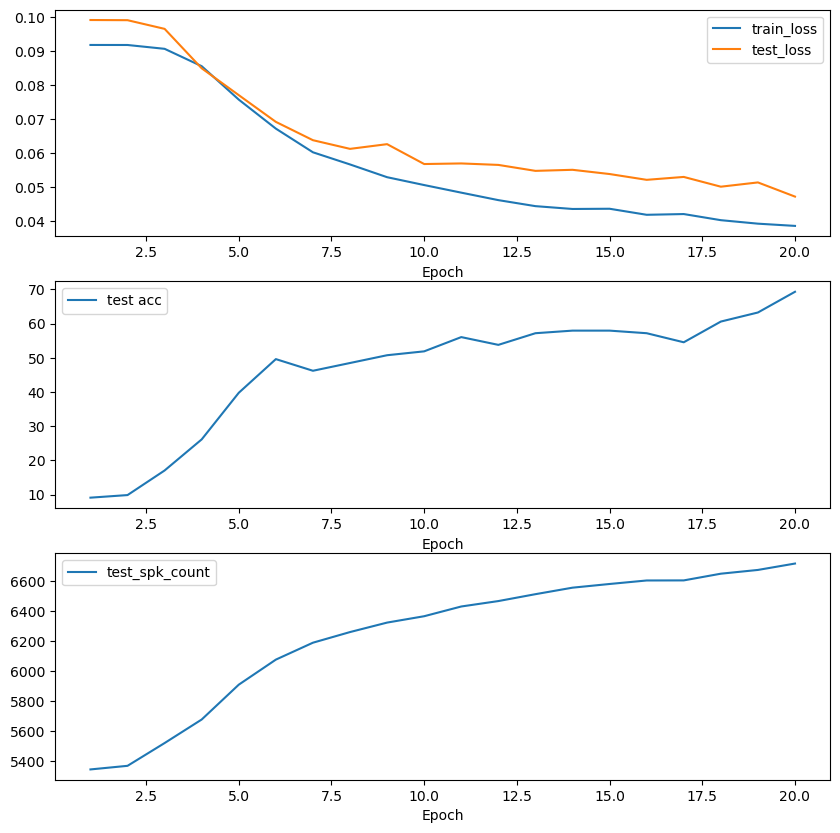

In [7]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv3D', 
        'out_channels': 16, 
        'kernel_size': 4,
        'fanin_delays': 2
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): FlattenSNNLayer()
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=8192, out_features=96, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[-0.0042, -0.0095, -0.0022,  ...,  0.0011, -0.0045,  0.0087],
        [-0.0011, -0.0056, -0.0004,  ..., -0.0040, -0.0072, -0.0017],
        [-0.0002, -0.0087,  0.0009,  ...,  0.0064, -0.0102, -0.0097],
        ...,
        [-0.0008, -0.0024,  0.0015,  ...,  0.0024,  0.0030, -0.0101],
        [-0.0079,  0.0050, -0.0013,  ...,  0.0020,  0.0093,  0.0033],
        [ 0.0088,  0.0004, -0.0093,  ..., -0.0021, -0.0035, -0.0104]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.0891,  0.0223,  0.0743,  ..., -0.0913, -0.0723

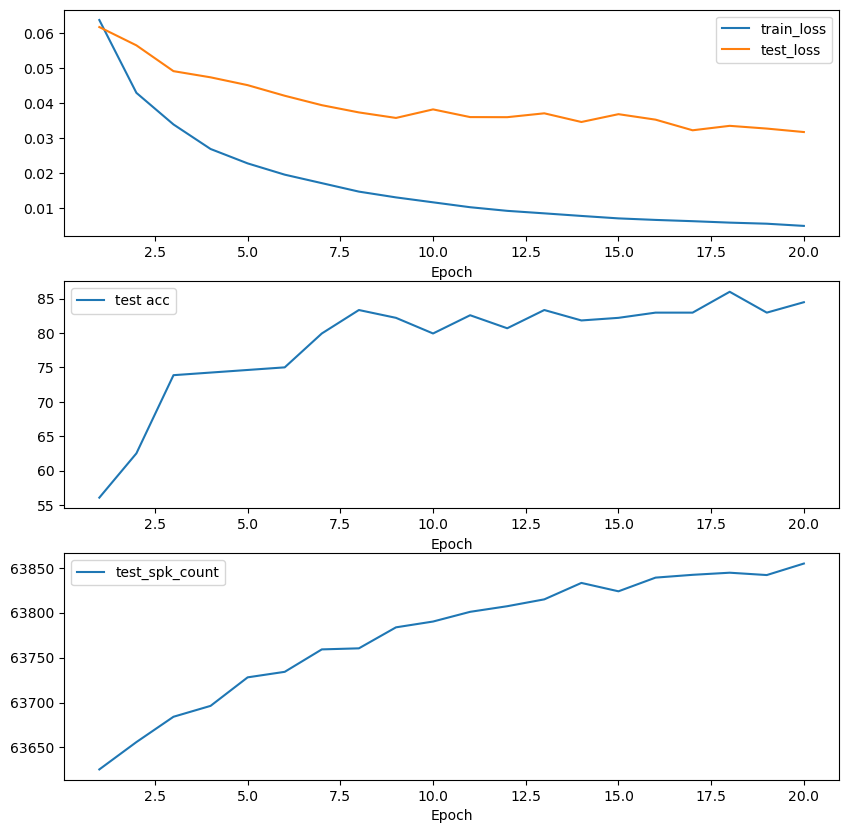

In [8]:
lr = 1e-3

model_config = [
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

best acc so far in dvsgestures, mimics dense with both input channels merged

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 96, kernel_size=(64, 64), stride=(64, 64), bias=False)
    )
    (1): FlattenSNNLayer()
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[-2.4182e-03,  1.0373e-02,  9.3931e-03,  ..., -9.9957e-03,
            1.0637e-02,  1.0003e-02],
          [-4.1551e-03,  1.8078e-03, -1.0742e-02,  ...,  3.7401e-03,
            8.3025e-03,  7.9705e-05],
          [-6.5748e-03, -3.0640e-03,  1.6166e-03,  ...,  5.1653e-03,
           -2.2093e-03, -7.3799e-03],
          ...,
          [ 1.8634e-03, -1.7378e-03,  1.0338e-03,  ...,  5.1915e-03,
           -1.4483e-03,  9.1079e-03],
          [ 4.4221e-03, -3.7811e-04, -3.5746e-03,  ..., -1.0863e-02,
           -3.2580e-03,  3.9407e-03],
     

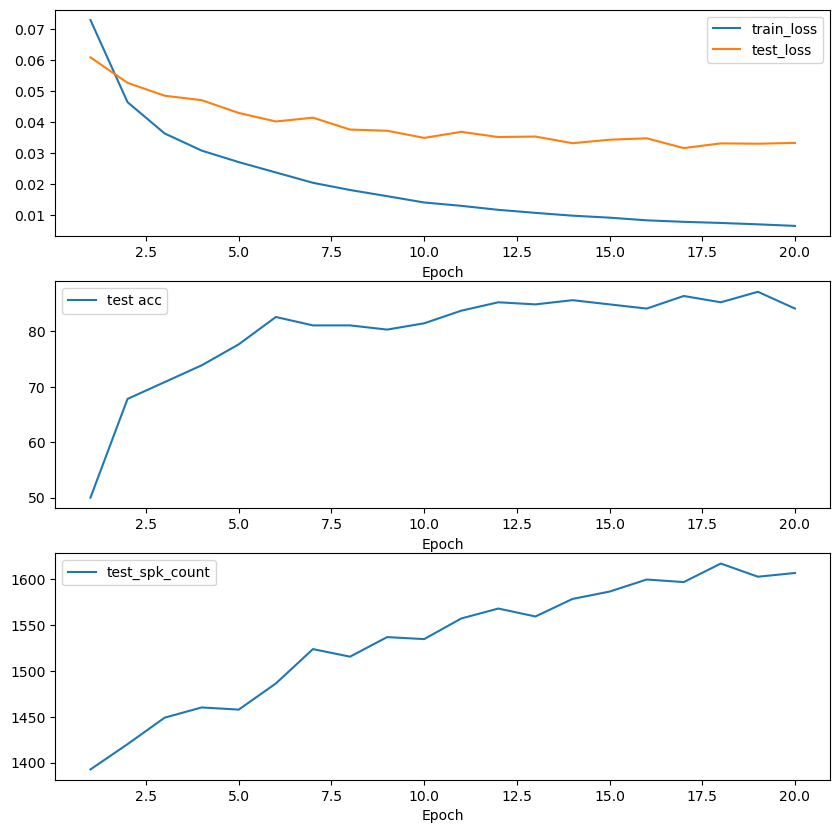

In [12]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 96, 
        'kernel_size': 64 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

128 neurons: 89%

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 128, kernel_size=(64, 64), stride=(64, 64), bias=False)
    )
    (1): FlattenSNNLayer()
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=128, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[-3.0489e-04, -1.1022e-02,  8.5996e-03,  ..., -7.4279e-03,
           -1.2976e-03, -3.2596e-03],
          [ 2.2967e-03,  8.5200e-03,  9.1211e-04,  ..., -9.1315e-03,
           -5.4115e-03,  7.5740e-04],
          [ 2.3219e-03,  1.0951e-03,  1.3989e-03,  ..., -7.8696e-03,
            6.2174e-03,  4.5738e-03],
          ...,
          [-9.9078e-04,  6.5691e-03, -8.0349e-03,  ..., -9.6456e-03,
           -2.9092e-03,  8.0325e-03],
          [ 6.3018e-03, -9.1300e-03,  2.5830e-03,  ...,  2.4960e-03,
            2.8721e-03, -5.6488e-03],
 

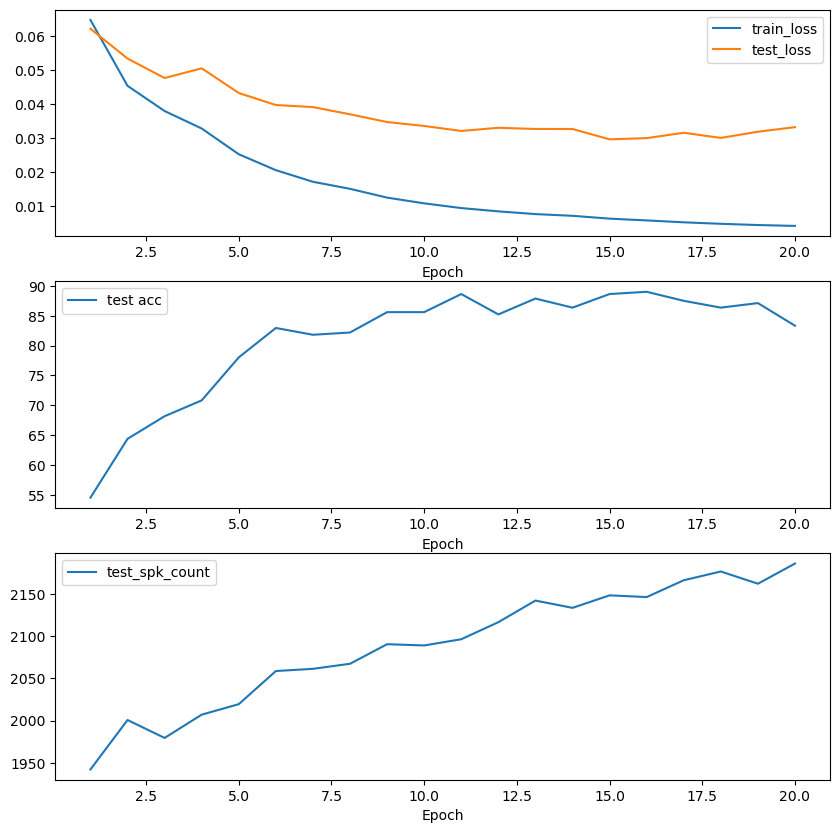

In [17]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 128, 
        'kernel_size': 64 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 128 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

same with mem-sum (84%)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 128, kernel_size=(64, 64), stride=(64, 64), bias=False)
    )
    (1): FlattenSNNLayer()
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=128, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
[Parameter containing:
tensor([[[[-1.2358e-03,  3.4368e-04,  7.3094e-04,  ...,  7.5108e-03,
           -5.4423e-04,  3.5642e-03],
          [ 1.8693e-04,  2.1720e-03, -1.0410e-02,  ..., -6.8279e-04,
            3.6400e-03, -6.0209e-03],
          [-1.0343e-02, -2.8775e-03,  8.8142e-03,  ..., -7.7076e-03,
            7.6648e-03, -1.0128e-02],
          ...,
          [ 7.7032e-03,  1.2359e-03, -1.0585e-02,  ..., -6.2779e-03,
            2.8606e-03, -1.0821e-03],
          [ 5.9542e-04, -1.0506e-02, -6.1544e-03,  ...,  6.9065e-03,
           -4.6281e-03, -1.161

c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 1.48939
Step [22/33], Loss: 0.89598
Step [33/33], Loss: 0.91086
Time elasped: 12.605729579925537
264
Test Loss: 1.0636505749490526
Avg spk_count per neuron for all 50 time-steps 2024.030303030303
Test Accuracy of the model on the test samples: 61.364

max acc: 61.36363636363637
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.83648
Step [22/33], Loss: 1.06689
Step [33/33], Loss: 0.48350
Time elasped: 17.32654881477356
264
Test Loss: 0.9782271782557169
Avg spk_count per neuron for all 50 time-steps 2103.0088383838383
Test Accuracy of the model on the test samples: 68.182

max acc: 68.18181818181819
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.65543
Step [22/33], Loss: 0.52657
Step [33/33], Loss: 0.34939
Time elasped: 19.124974012374878
264
Test Loss: 0.7250467770629458
Avg spk_count per neuron for all 50 time-steps 2064.318181818182
Test Accuracy of the model on the test samples: 78.030

max acc: 78.03030303030303
Epoch [

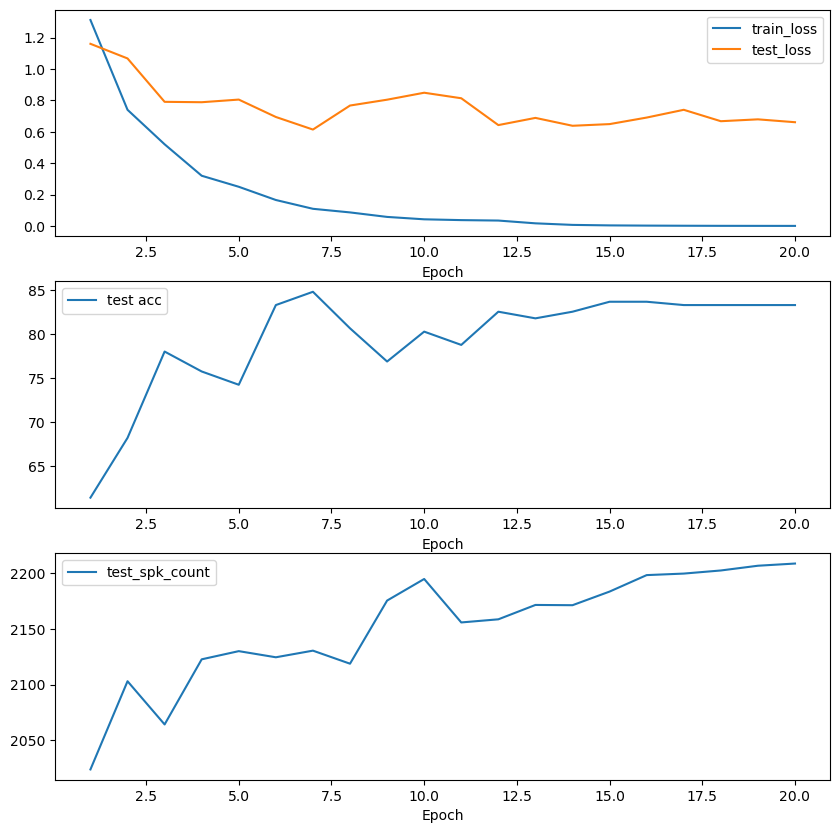

In [18]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 128, 
        'kernel_size': 64 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 128 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

"dynamic average pooling layer"

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(1, 96, kernel_size=(32, 32), stride=(32, 32), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[-0.0336,  0.2029],
          [-0.1443,  0.3411]],

         [[ 0.0044, -0.1537],
          [-0.1261, -0.1129]]]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[[[-0.0211, -0.0206,  0.0114,  ...,  0.0131, -0.0114, -0.0154],
          [-0.0287,  0.0171,  0.0234,  ..., -0.0081, -0.0126, -0.0198],
          [ 0.0232,  0.0228, -0.0234,  ..., -0.0040, -0.0209,  0.0302],
          ...,
          [-0.0179,  0.0189, -0.02

c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 0.09069
Step [22/33], Loss: 0.09002
Step [33/33], Loss: 0.08567
Time elasped: 6.8338165283203125
264
Test Loss: 0.08869735068745083
Avg spk_count per neuron for all 50 time-steps 1033.627840909091
Test Accuracy of the model on the test samples: 14.773

max acc: 14.772727272727273
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.08900
Step [22/33], Loss: 0.08486
Step [33/33], Loss: 0.08014
Time elasped: 6.316992998123169
264
Test Loss: 0.08010063485966788
Avg spk_count per neuron for all 50 time-steps 1125.7035984848485
Test Accuracy of the model on the test samples: 26.136

max acc: 26.136363636363637
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.08053
Step [22/33], Loss: 0.07675
Step [33/33], Loss: 0.07439
Time elasped: 7.13901686668396
264
Test Loss: 0.07236250241597493
Avg spk_count per neuron for all 50 time-steps 1421.4431818181818
Test Accuracy of the model on the test samples: 34.470

max acc: 34.46969696969697
Epo

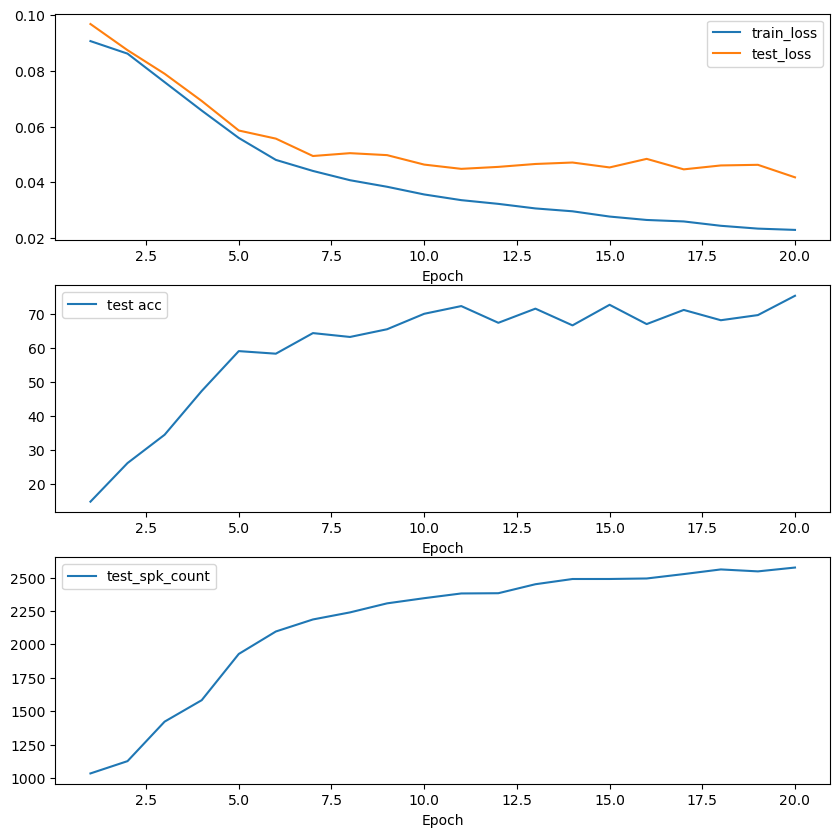

In [16]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 1, 
        'kernel_size': 2 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 96, 
        'kernel_size': 32 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 6, kernel_size=(16, 16), stride=(16, 16), bias=False)
    )
    (1): FlattenSNNLayer()
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=96, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[ 0.0155,  0.0318, -0.0162,  ..., -0.0012, -0.0381,  0.0040],
          [ 0.0108, -0.0324, -0.0163,  ...,  0.0348, -0.0030,  0.0288],
          [ 0.0374, -0.0038, -0.0139,  ..., -0.0110, -0.0056,  0.0157],
          ...,
          [-0.0418, -0.0270,  0.0278,  ...,  0.0340,  0.0258, -0.0039],
          [ 0.0192, -0.0309, -0.0151,  ..., -0.0065,  0.0029,  0.0021],
          [ 0.0269, -0.0415,  0.0134,  ...,  0.0281,  0.0167, -0.0243]],

         [[ 0.0294,  0.0074, -0.0269,  ...,  0.0005, -0.0007,  0.0358],
          [-0.0099, -0.0417, -0.007

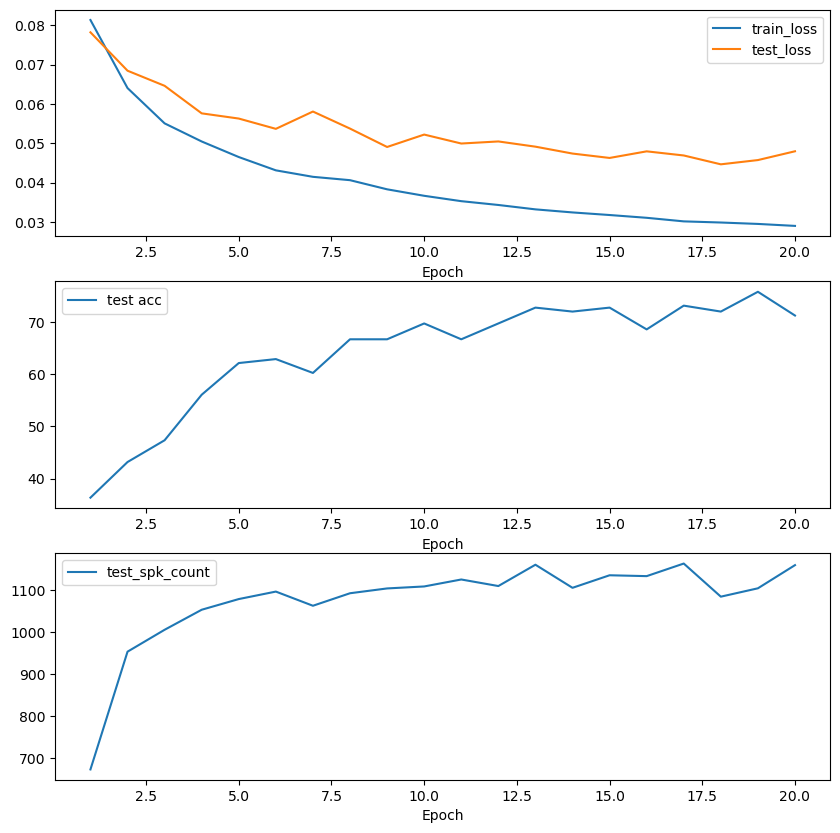

In [14]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 96//16, 
        'kernel_size': 64//4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 96, kernel_size=(16, 16), stride=(16, 16), bias=False)
    )
    (1): FlattenSNNLayer()
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=1536, out_features=96, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[-2.5331e-02, -3.9268e-02, -4.3593e-02,  ...,  3.0825e-02,
           -3.0038e-02, -2.2820e-02],
          [-3.8290e-02, -1.9790e-02, -4.4138e-02,  ...,  4.3496e-02,
            3.7067e-02,  1.5083e-02],
          [ 9.7351e-03, -4.0619e-03,  4.2602e-02,  ...,  1.2167e-02,
            3.0245e-02, -1.8036e-02],
          ...,
          [-3.0001e-02,  3.6053e-02, -2.9828e-03,  ..., -2.5908e-03,
            5.1949e-03,  1.4419e-02],
          [ 1.5904e-02, -9.4366e-03, -2.4873e-02,  ...,  3.6356e-03,
            2.5346e-02, -3.1576e-02],
   

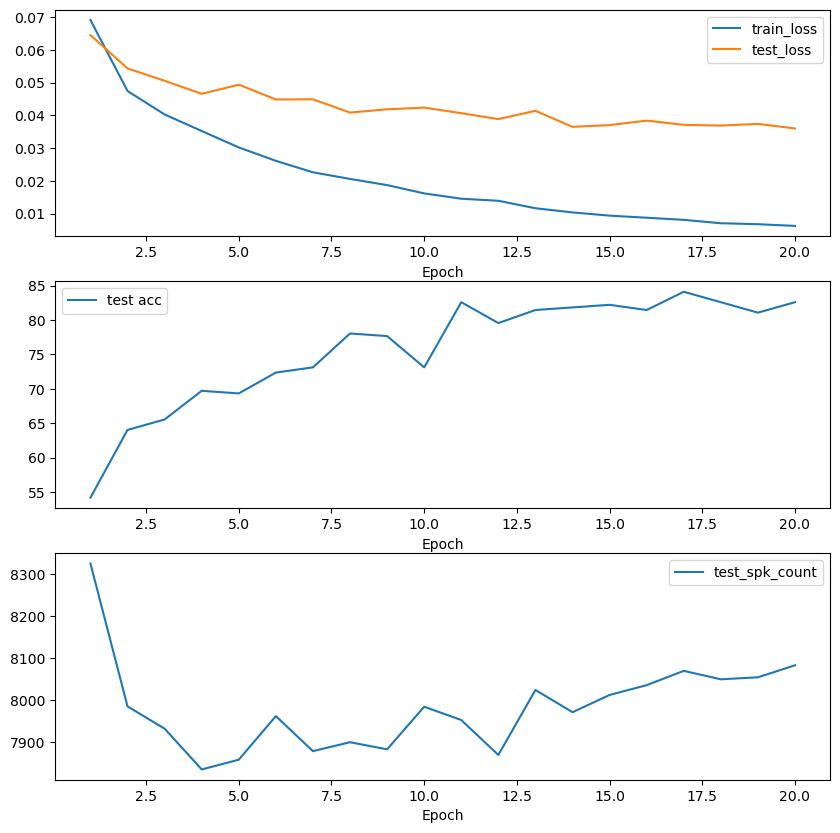

In [15]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 96, 
        'kernel_size': 64//4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

with overlapping kernels and average pooling (new features)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 2, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
    (1): FlattenSNNLayer()
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=1800, out_features=96, bias=False)
    )
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
[Parameter containing:
tensor([[[[-0.0148, -0.0061, -0.0663,  0.0407],
          [-0.1011, -0.0312,  0.0685,  0.1659],
          [ 0.0416, -0.0600,  0.0170, -0.0198],
          [ 0.0722,  0.0202,  0.0692,  0.1714]],

         [[-0.0734, -0.0062,  0.0407, -0.0012],
          [-0.0169, -0.1564, -0.1525, -0.1591],
          [-0.1730, -0.1646, -0.1339, -0.1594],
          [-0.1658,  0.0775,  0.1084,  0.1195]]],


        [[[ 0.0952,  0.0599,  0.0779, -0.0978],
          [ 0.1592, -0.0122,  0.1525,  0.0542],
          [ 0.1384,  0.1410, -0.0369, -0.0514],
          [ 0.0266, -0.0

c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 0.07615
Step [22/33], Loss: 0.06694
Step [33/33], Loss: 0.04916
Time elasped: 89.69849300384521
264
Test Loss: 0.05311060779624515
Avg spk_count per neuron for all 50 time-steps 5678.174242424242
Test Accuracy of the model on the test samples: 55.303

max acc: 55.303030303030305
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.04312
Step [22/33], Loss: 0.04325
Step [33/33], Loss: 0.02756
Time elasped: 6.68549370765686
264
Test Loss: 0.04668194717831082
Avg spk_count per neuron for all 50 time-steps 5581.026515151515
Test Accuracy of the model on the test samples: 67.424

max acc: 67.42424242424242
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.03136
Step [22/33], Loss: 0.02609
Step [33/33], Loss: 0.03060
Time elasped: 6.949561595916748
264
Test Loss: 0.04277601217230161
Avg spk_count per neuron for all 50 time-steps 5837.907828282829
Test Accuracy of the model on the test samples: 73.864

max acc: 73.86363636363636
Epoch [

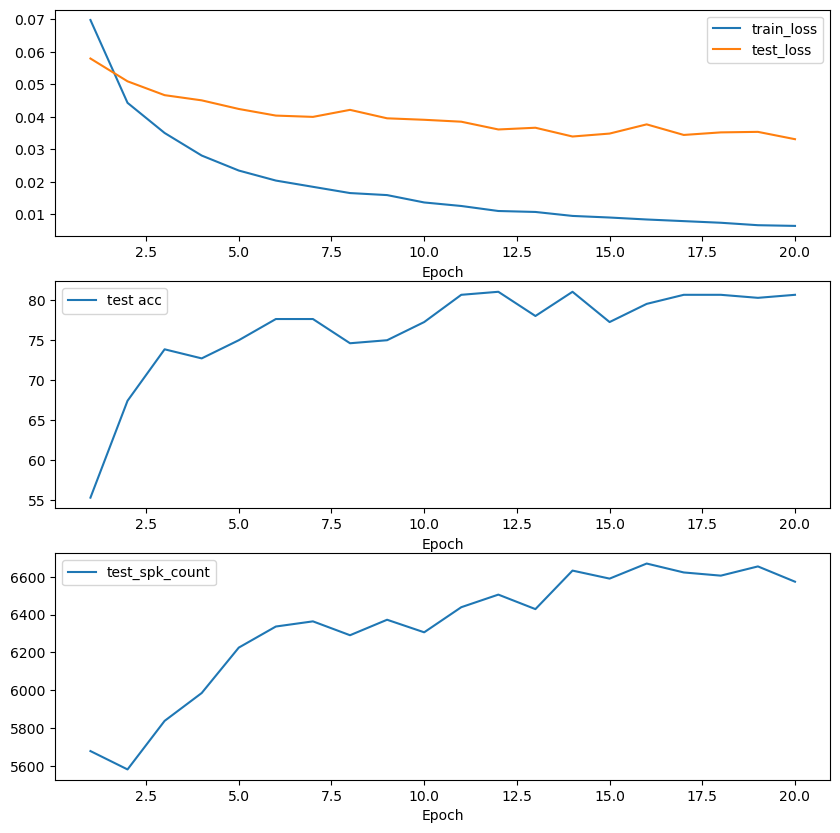

In [3]:
lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 2, 
        'kernel_size': 4,
        'stride': 1, 
        'avg_pooling': True
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 96 # Number of neurons in this dense layer
    }
]

num_epochs = 20

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Parecido a BAM_SLDK pero sin conv3d

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(10, 24, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (2): Conv2DSNNLayer(
      (conv): Conv2d(24, 48, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (3): FlattenSNNLayer()
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=960, out_features=20, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=20, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
[Parameter containing:
tensor([[[[ 0.0834,  0.0882,  0.0467, -0.0674, -0.0653],
          [ 0.1301, -0.0869,  0.0824, -0.0216,  0.1001],
          [ 0.0275,  0.0090, -0.1253, -0.0426,  0.0324],
          [ 0.1404, -0.0241, -0.0449, -0.1390,  0.0999],
          [ 0.1351,  0.0505, -0.1227,  0.1368, -0.0532]],

         [[ 0.0700,  0.0393, -0.0478,  0.0375, -

c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 2.39790
Step [22/33], Loss: 2.39790
Step [33/33], Loss: 2.36992
Time elasped: 9.65654182434082
264
Test Loss: 2.3777582910325794
Avg spk_count per neuron for all 50 time-steps 10840.094696969696
Test Accuracy of the model on the test samples: 15.909

max acc: 15.909090909090908
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 2.32306
Step [22/33], Loss: 2.32593
Step [33/33], Loss: 2.09934
Time elasped: 9.153302431106567
264
Test Loss: 2.223718245824178
Avg spk_count per neuron for all 50 time-steps 9331.973484848484
Test Accuracy of the model on the test samples: 21.970

max acc: 21.96969696969697
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 2.19730
Step [22/33], Loss: 2.34760
Step [33/33], Loss: 2.15413
Time elasped: 11.31722116470337
264
Test Loss: 2.146155503061083
Avg spk_count per neuron for all 50 time-steps 8213.518181818183
Test Accuracy of the model on the test samples: 22.348

max acc: 22.348484848484848
Epoch [4/2

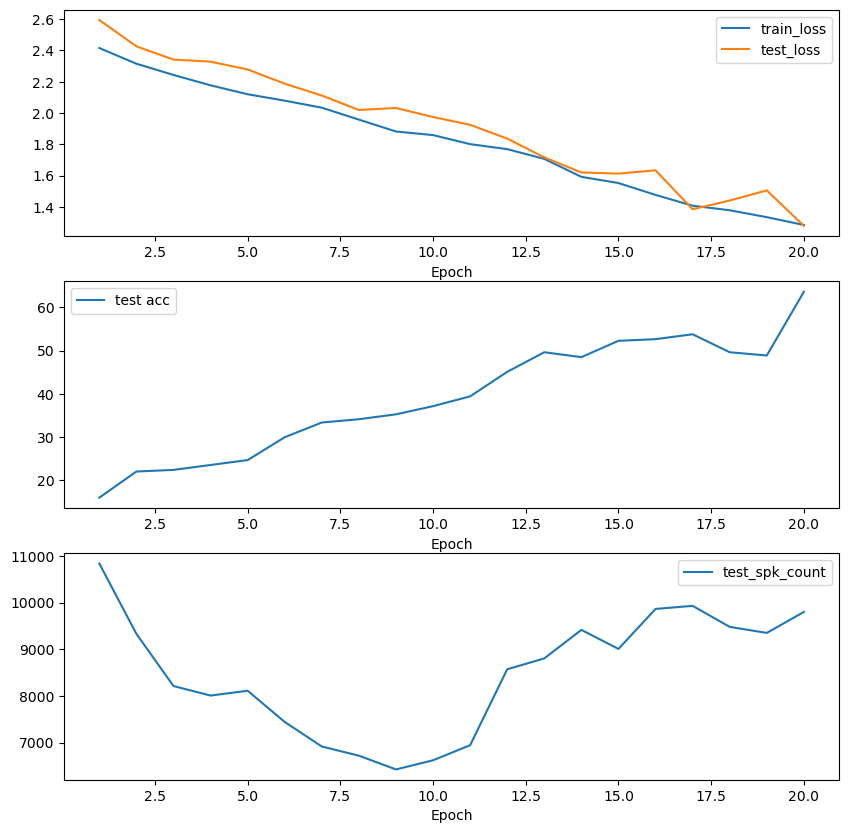

In [7]:
num_epochs = 20

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 10, 
        'kernel_size': 5, 
        'stride': 1,
        'avg_pooling': True
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 2, 
        'stride': 2,
        'avg_pooling': True 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 48, 
        'kernel_size': 2, 
        'stride': 2,
        'avg_pooling': True
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 20, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 20, 'stride': 1}
        
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

In [ ]:
for layer in snn.layers:
    print(layer.output_shape)

(10, 30, 30)
(24, 5, 5)
(48, 0, 0)
(0,)
(20,)
(11,)


Conv2DSNNLayer(
  (conv): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
)

Like BAM-SLDK (only missing BNTT)

In [3]:
num_epochs = 50

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 10, 
        'kernel_size': 5, 
        'stride': 1,
        'avg_pooling': True
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 24, 
        'kernel_size': 2, 
        'fanin_delays': 15,
        'avg_pooling': True 
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 48, 
        'kernel_size': 2, 
        'fanin_delays': 20,
        'avg_pooling': True
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 20, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 20, 'stride': 1}
        
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

for layer in snn.layers:
    print(layer.output_shape)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
(10, 30, 30)
(24, 7, 7)
(48, 1, 1)
(48,)
(20,)
(11,)
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
    )
    (1): Conv3DSNNLayer(
      (conv): Conv3d(10, 24, kernel_size=(15, 2, 2), stride=(1, 2, 2), bias=False)
    )
    (2): Conv3DSNNLayer(
      (conv): Conv3d(24, 48, kernel_size=(20, 2, 2), stride=(1, 2, 2), bias=False)
    )
    (3): FlattenSNNLayer()
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=960, out_features=20, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=20, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.09091
Step [22/33], Loss: 0.09091
Step [33/33], Loss: 0.09091
Time elasped: 28.464425802230835
264
Test Loss: 0.09090909361839294
Avg spk_count per neuron for all 50 time-steps 9097.007575757576
Test Accuracy of the model on the t

KeyboardInterrupt: 

In [5]:
num_epochs = 50

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 10, 
        'kernel_size': 5, 
        'stride': 1,
        'avg_pooling': True
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 2, 
        'stride': 2,
        'avg_pooling': True 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 48, 
        'kernel_size': 2, 
        'stride': 2,
        'avg_pooling': True
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 20, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 20, 'stride': 1}
        
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='spk_count', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(10, 24, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (2): Conv2DSNNLayer(
      (conv): Conv2d(24, 48, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (3): FlattenSNNLayer()
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=960, out_features=20, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=20, out_features=11, bias=False)
    )
  )
  (criterion): MSELoss()
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 0.09091
Step [22/33], Loss: 0.09091
Step [33/33], Loss: 0.09091
Time elasped: 10.490470886230469
264
Test Loss: 0.09090909361839294
Avg spk_count per neuron for all 50 time-steps 6781.115909090909
Test Accuracy of the model on the test samples: 9.091

max acc: 9.090909090909092
Epoch [2/50], learni

KeyboardInterrupt: 

In [6]:
num_epochs = 50

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 10, 
        'kernel_size': 5, 
        'stride': 1,
        'avg_pooling': True
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 24, 
        'kernel_size': 2, 
        'fanin_delays': 15,
        'avg_pooling': True 
    }, 
    {
        'type': 'Conv3D', 
        'out_channels': 48, 
        'kernel_size': 2, 
        'fanin_delays': 20,
        'avg_pooling': True
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 20, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 20, 'stride': 1}
        
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn.set_layers()
snn.to(device)

for layer in snn.layers:
    print(layer.output_shape)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

Delta t: 60.0 ms
(10, 30, 30)
(24, 7, 7)
(48, 1, 1)
(48,)
(20,)
(11,)
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
    )
    (1): Conv3DSNNLayer(
      (conv): Conv3d(10, 24, kernel_size=(15, 2, 2), stride=(1, 2, 2), bias=False)
    )
    (2): Conv3DSNNLayer(
      (conv): Conv3d(24, 48, kernel_size=(20, 2, 2), stride=(1, 2, 2), bias=False)
    )
    (3): FlattenSNNLayer()
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=960, out_features=20, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=20, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 2.28902
Step [22/33], Loss: 2.12358
Step [33/33], Loss: 2.07122
Time elasped: 42.990639448165894
264
Test Loss: 2.0376753542158337
Avg spk_count per neuron for all 50 time-steps 9741.119696969698
Test Accuracy of the model 

KeyboardInterrupt: 